In [1]:
import pandas as pd

In [2]:
df = pd.read_csv('data/user_rec.csv', index_col=False)

In [3]:
del df['Unnamed: 0']

In [4]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 87786 entries, 0 to 87785
Data columns (total 2 columns):
user_id            87786 non-null int64
recommendations    87786 non-null object
dtypes: int64(1), object(1)
memory usage: 1.3+ MB


In [5]:
df2 = pd.read_csv('data/recipe_rec.csv')

In [6]:
df2.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3913 entries, 0 to 3912
Data columns (total 3 columns):
Unnamed: 0         3913 non-null int64
recipe_id          3913 non-null int64
recommendations    3913 non-null object
dtypes: int64(2), object(1)
memory usage: 91.8+ KB


In [7]:
import pickle
with open('data/recipe_dict.pkl', 'rb') as f:
    recipe_dict = pickle.load(f)

In [8]:
import numpy as np
rec_list = pd.DataFrame.from_dict(recipe_dict, orient='index')

In [9]:
rec_list.reset_index(inplace=True)

In [10]:
rec_list.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3913 entries, 0 to 3912
Data columns (total 2 columns):
index    3913 non-null object
0        3913 non-null int64
dtypes: int64(1), object(1)
memory usage: 61.2+ KB


In [11]:
rec_list.columns = ['recipe', 'id_num']

In [12]:
rec_list.head()

,recipe,id_num
0,Cabbage Koora,0
1,Spinach Pinwheels,1
2,Cincinnati-Style Chili,2
3,Mediterranean-Style Eggplant Pasta,3
4,Minted Marinated Zucchini,4


In [13]:
X = rec_list['recipe'].values

In [14]:
# import nltk

In [15]:
from sklearn.decomposition import LatentDirichletAllocation as LDA

In [16]:
from sklearn.feature_extraction.text import CountVectorizer

In [17]:
from sklearn.feature_extraction.text import TfidfVectorizer, CountVectorizer
from sklearn.decomposition import NMF, LatentDirichletAllocation
# from sklearn.datasets import fetch_20newsgroups

In [134]:
from time import time
n_samples = len(X)
n_features = 500
n_components = 8
n_top_words = 5


def print_top_words(model, feature_names, n_top_words):
    for topic_idx, topic in enumerate(model.components_):
        message = "Topic #%d: " % topic_idx
        message += " ".join([feature_names[i]
                             for i in topic.argsort()[:-n_top_words - 1:-1]])
        print(message)
    print()


# Load the 20 newsgroups dataset and vectorize it. We use a few heuristics
# to filter out useless terms early on: the posts are stripped of headers,
# footers and quoted replies, and common English words, words occurring in
# only one document or in at least 95% of the documents are removed.

# print("Loading dataset...")
# t0 = time()
# dataset = fetch_20newsgroups(shuffle=True, random_state=1,
#                              remove=('headers', 'footers', 'quotes'))
# data_samples = dataset.data[:n_samples]
# print("done in %0.3fs." % (time() - t0))

# Use tf-idf features for NMF.
print("Extracting tf-idf features for NMF...")
tfidf_vectorizer = TfidfVectorizer(max_df=0.95, min_df=2,
                                   max_features=n_features,
                                   stop_words='english')
t0 = time()
tfidf = tfidf_vectorizer.fit_transform(X)
print("done in %0.3fs." % (time() - t0))

# Use tf (raw term count) features for LDA.
print("Extracting tf features for LDA...")
tf_vectorizer = CountVectorizer(max_df=0.95, min_df=2,
                                max_features=n_features,
                                stop_words='english')
t0 = time()
tf = tf_vectorizer.fit_transform(X)
print("done in %0.3fs." % (time() - t0))
print()

# Fit the NMF model
print("Fitting the NMF model (Frobenius norm) with tf-idf features, "
      "n_samples=%d and n_features=%d..."
      % (n_samples, n_features))
t0 = time()
nmf = NMF(n_components=n_components, random_state=1,
          alpha=.1, l1_ratio=.5).fit(tfidf)
print("done in %0.3fs." % (time() - t0))

print("\nTopics in NMF model (Frobenius norm):")
tfidf_feature_names = tfidf_vectorizer.get_feature_names()
print_top_words(nmf, tfidf_feature_names, n_top_words)

# # Fit the NMF model
# print("Fitting the NMF model (generalized Kullback-Leibler divergence) with "
#       "tf-idf features, n_samples=%d and n_features=%d..."
#       % (n_samples, n_features))
# t0 = time()
# nmf = NMF(n_components=n_components, random_state=1,
#           solver='mu', max_iter=1000, alpha=.1,
#           l1_ratio=.5).fit(tfidf)
# print("done in %0.3fs." % (time() - t0))

print("\nTopics in NMF model (generalized Kullback-Leibler divergence):")
tfidf_feature_names = tfidf_vectorizer.get_feature_names()
print_top_words(nmf, tfidf_feature_names, n_top_words)

print("Fitting LDA models with tf features, "
      "n_samples=%d and n_features=%d..."
      % (n_samples, n_features))
lda = LatentDirichletAllocation(n_components=n_components, max_iter=5,
                                learning_method='online',
                                learning_offset=50.,
                                random_state=0)
t0 = time()
lda.fit(tf)
# comp = lda.fit_transform(tf)
# lda_labels = comp.argmax(axis=1)
print("done in %0.3fs." % (time() - t0))

print("\nTopics in LDA model:")
tf_feature_names = tf_vectorizer.get_feature_names()
print_top_words(lda, tf_feature_names, n_top_words)

Extracting tf-idf features for NMF...
done in 0.121s.
Extracting tf features for LDA...
done in 0.072s.

Fitting the NMF model (Frobenius norm) with tf-idf features, n_samples=3913 and n_features=500...
done in 0.329s.

Topics in NMF model (Frobenius norm):
Topic #0: salad spinach ii tomato greek
Topic #1: soup vegetable lentil tomato squash
Topic #2: sauce cheese tomato easy cream
Topic #3: potato sweet casserole zucchini curry
Topic #4: vegetarian chili easy lasagna cooker
Topic #5: bean black vegan burgers green
Topic #6: pasta pesto tomato summer primavera
Topic #7: potatoes mashed sweet baked garlic


Topics in NMF model (generalized Kullback-Leibler divergence):
Topic #0: salad spinach ii tomato greek
Topic #1: soup vegetable lentil tomato squash
Topic #2: sauce cheese tomato easy cream
Topic #3: potato sweet casserole zucchini curry
Topic #4: vegetarian chili easy lasagna cooker
Topic #5: bean black vegan burgers green
Topic #6: pasta pesto tomato summer primavera
Topic #7: pota

In [67]:
from sklearn.manifold import TSNE

In [22]:
from sklearn.decomposition import TruncatedSVD

In [73]:
import matplotlib.pyplot as plt
plt.style.use('ggplot')
def clustering_algorithm(tfidf, labels):

    svd = TruncatedSVD(algorithm='randomized', random_state=42)
    X_new = svd.fit_transform(tfidf)
    tsne_mod = TSNE(n_components=2, verbose=1, random_state=0, perplexity=40)
    coords = tsne_mod.fit_transform(X_new)
    return coords[:, 0], coords[:, 1]
# #     fig, ax = plt.subplot(figsize=(8, 10))
#     plt.scatter(x, y, alpha=0.5, cmap=labels)
#     plt.show()

nmf_w = nmf.fit_transform(tfidf)
labels = nmf_w.argmax(axis=1)
x, y = clustering_algorithm(tfidf, labels)

[t-SNE] Computing 121 nearest neighbors...
[t-SNE] Indexed 3913 samples in 0.022s...
[t-SNE] Computed neighbors for 3913 samples in 0.195s...
[t-SNE] Computed conditional probabilities for sample 1000 / 3913
[t-SNE] Computed conditional probabilities for sample 2000 / 3913
[t-SNE] Computed conditional probabilities for sample 3000 / 3913
[t-SNE] Computed conditional probabilities for sample 3913 / 3913
[t-SNE] Mean sigma: 0.000000
[t-SNE] KL divergence after 250 iterations with early exaggeration: 59.597775
[t-SNE] Error after 1000 iterations: 0.510649


[t-SNE] Computing 121 nearest neighbors...
[t-SNE] Indexed 3913 samples in 0.214s...
[t-SNE] Computed neighbors for 3913 samples in 25.852s...
[t-SNE] Computed conditional probabilities for sample 1000 / 3913
[t-SNE] Computed conditional probabilities for sample 2000 / 3913
[t-SNE] Computed conditional probabilities for sample 3000 / 3913
[t-SNE] Computed conditional probabilities for sample 3913 / 3913
[t-SNE] Mean sigma: 0.000000
[t-SNE] KL divergence after 250 iterations with early exaggeration: 94.577179
[t-SNE] Error after 1000 iterations: 1.814774


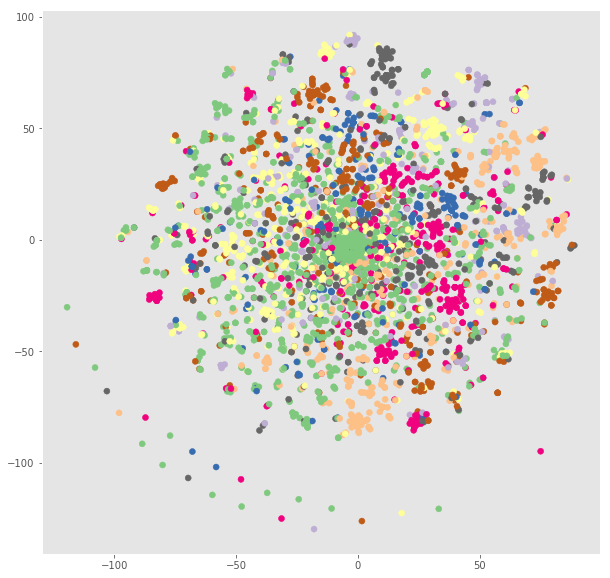

In [90]:
%matplotlib inline
x, y = clustering_algorithm2(tfidf, labels)
fig, ax = plt.subplots(figsize=(10, 10))
ax.scatter(x, y, c=labels, cmap='Accent')
ax.grid(False)


In [ ]:
def clustering_algorithm2(tfidf, labels):

    svd = TruncatedSVD(algorithm='randomized', random_state=42)
    X_new = svd.fit_transform(tfidf)
    tsne_mod = TSNE(n_components=3, verbose=1, random_state=0, perplexity=40)
    coords = tsne_mod.fit_transform(X_new)
    return coords[:, 0], coords[:, 1], coords[:, 2]

In [138]:
comp = lda.fit_transform(tf)
lda_labels = comp.argmax(axis=1)
x2, y2, z2 = clustering_algorithm2(tf, lda_labels)
# fig, ax = plt.subplots(figsize=(10, 10))
# ax.scatter(x2, y2, c=lda_labels, cmap='Accent')
# ax.grid(False)

[t-SNE] Computing 121 nearest neighbors...
[t-SNE] Indexed 3913 samples in 0.234s...
[t-SNE] Computed neighbors for 3913 samples in 25.029s...
[t-SNE] Computed conditional probabilities for sample 1000 / 3913
[t-SNE] Computed conditional probabilities for sample 2000 / 3913
[t-SNE] Computed conditional probabilities for sample 3000 / 3913
[t-SNE] Computed conditional probabilities for sample 3913 / 3913
[t-SNE] Mean sigma: 0.000000
[t-SNE] KL divergence after 250 iterations with early exaggeration: 79.307747
[t-SNE] Error after 1000 iterations: 1.715164


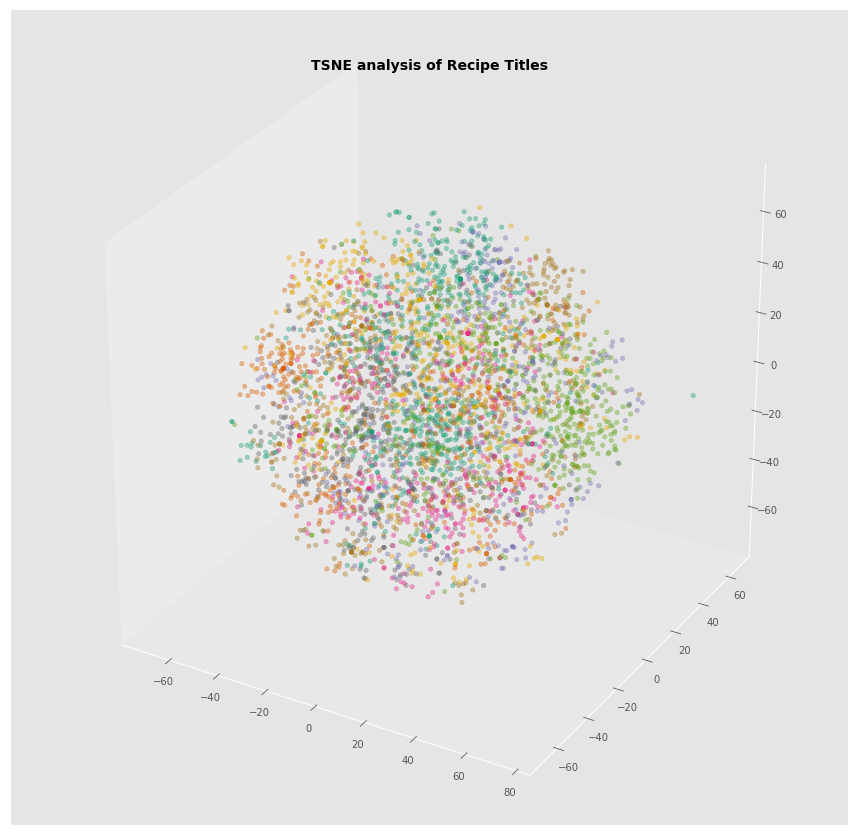

In [160]:
"""3-D plotting"""
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
fig = plt.figure(figsize=(15, 15))
ax = fig.add_subplot(111, projection='3d')
ax.scatter(x2, y2, z2, zdir='z', c=lda_labels, s=20, cmap='Dark2', alpha=0.4)
ax.set_title('TSNE analysis of Recipe Titles', fontsize=14, fontweight='bold')
ax.grid(False)
plt.savefig('data/title_tsne.png')

In [155]:
# comp = lda.fit_transform(tf)
# lda_labels = comp.argmax(axis=1)
x4, y4, z4 = clustering_algorithm2(tfidf, labels)

[t-SNE] Computing 121 nearest neighbors...
[t-SNE] Indexed 3913 samples in 0.211s...
[t-SNE] Computed neighbors for 3913 samples in 20.769s...
[t-SNE] Computed conditional probabilities for sample 1000 / 3913
[t-SNE] Computed conditional probabilities for sample 2000 / 3913
[t-SNE] Computed conditional probabilities for sample 3000 / 3913
[t-SNE] Computed conditional probabilities for sample 3913 / 3913
[t-SNE] Mean sigma: 0.000000
[t-SNE] KL divergence after 250 iterations with early exaggeration: 116.020950
[t-SNE] Error after 1000 iterations: 1.809821


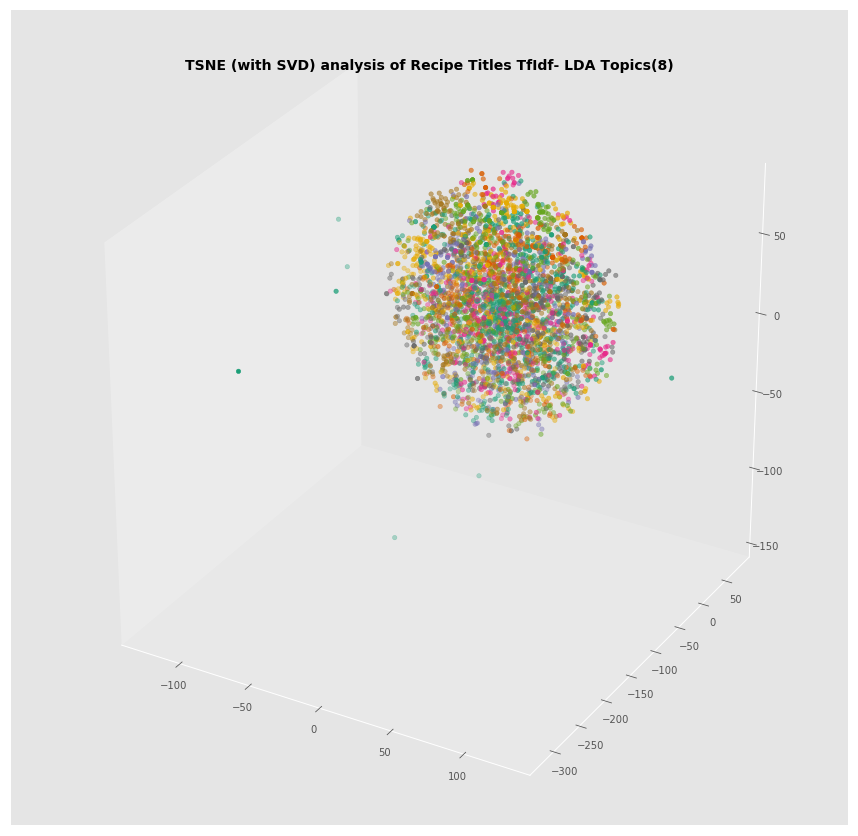

In [156]:
fig = plt.figure(figsize=(15, 15))
ax = fig.add_subplot(111, projection='3d')
ax.scatter(x4, y4, z4, zdir='z', c=lda_labels, s=20, cmap='Dark2')
ax.set_title('TSNE (with SVD) analysis of Recipe Titles TfIdf- LDA Topics(8)', fontsize=14, fontweight='bold')
ax.grid(False)

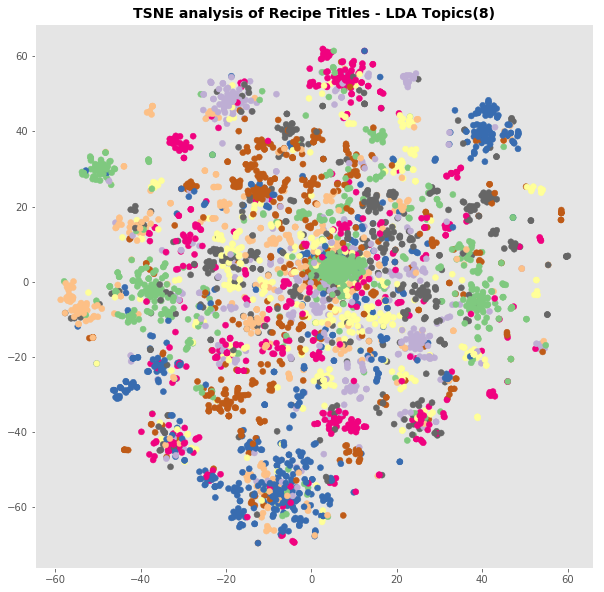

In [136]:
fig, ax = plt.subplots(figsize=(10, 10))
ax.scatter(x2, y2, c=lda_labels, cmap='Accent')
ax.grid(False)
ax.set_title('TSNE analysis of Recipe Titles - LDA Topics(8)', fontsize=14, fontweight='bold')
# ax.set_xticklabels(None)

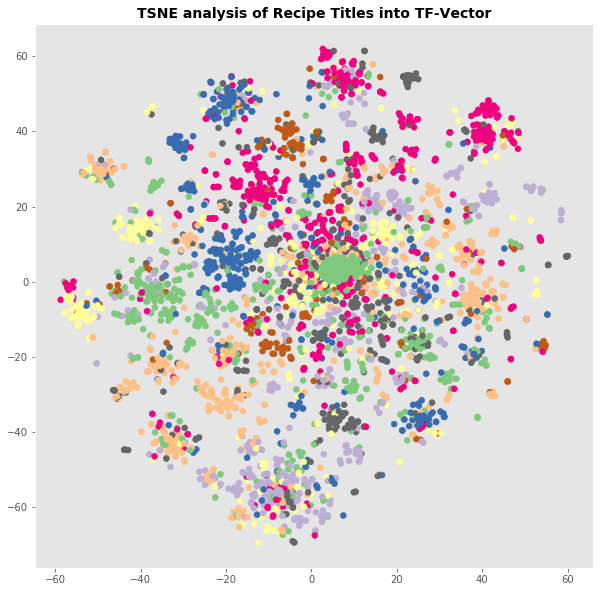

In [88]:
fig, ax = plt.subplots(figsize=(10, 10))
ax.scatter(x2, y2, c=lda_labels, cmap='Accent')
ax.grid(False)
ax.set_title('TSNE analysis of Recipe Titles into TF-Vector', fontsize=14, fontweight='bold')
# ax.set_xticklabels(None)

In [51]:
bb = comp.argmax(axis=1)

In [54]:
bb

array([683, 916, 241, 848, 416, 738,  41,  58, 264, 716, 606, 384, 957,
       808, 554, 158, 174, 913, 792, 664])

In [55]:
comp.shape

(20, 958)

In [126]:
from sklearn.cluster import KMeans

num_clusters = 20

km = KMeans(n_clusters=num_clusters)

%time km.fit(tfidf)

clusters = km.labels_

CPU times: user 1.95 s, sys: 45.6 ms, total: 2 s
Wall time: 2.13 s


In [102]:
x3, y3 = clustering_algorithm(tfidf, clusters)

[t-SNE] Computing 121 nearest neighbors...
[t-SNE] Indexed 3913 samples in 0.012s...
[t-SNE] Computed neighbors for 3913 samples in 0.179s...
[t-SNE] Computed conditional probabilities for sample 1000 / 3913
[t-SNE] Computed conditional probabilities for sample 2000 / 3913
[t-SNE] Computed conditional probabilities for sample 3000 / 3913
[t-SNE] Computed conditional probabilities for sample 3913 / 3913
[t-SNE] Mean sigma: 0.000000
[t-SNE] KL divergence after 250 iterations with early exaggeration: 59.597775
[t-SNE] Error after 1000 iterations: 0.510649


In [127]:
cc = km.cluster_centers_

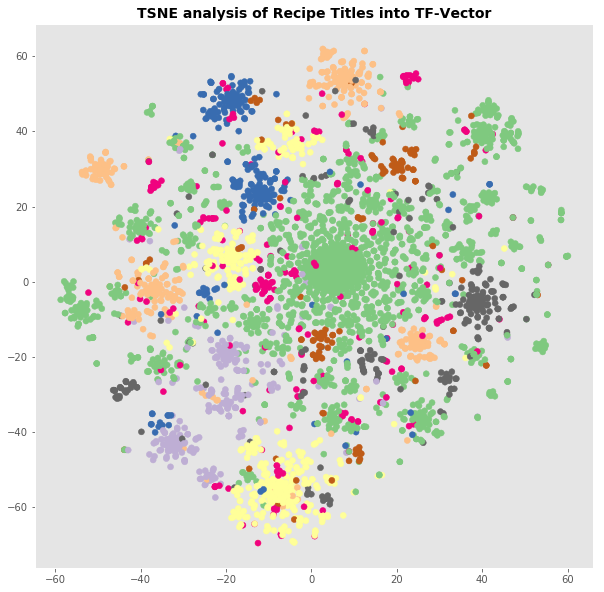

In [130]:
fig, ax = plt.subplots(figsize=(10, 10))
ax.scatter(x2, y2, c=clusters, cmap='Accent')
ax.grid(False)
ax.set_title('TSNE analysis of Recipe Titles into TF-Vector', fontsize=14, fontweight='bold')
# ax.set_xticklabels(None)

In [129]:
clusters.shape

(3913,)

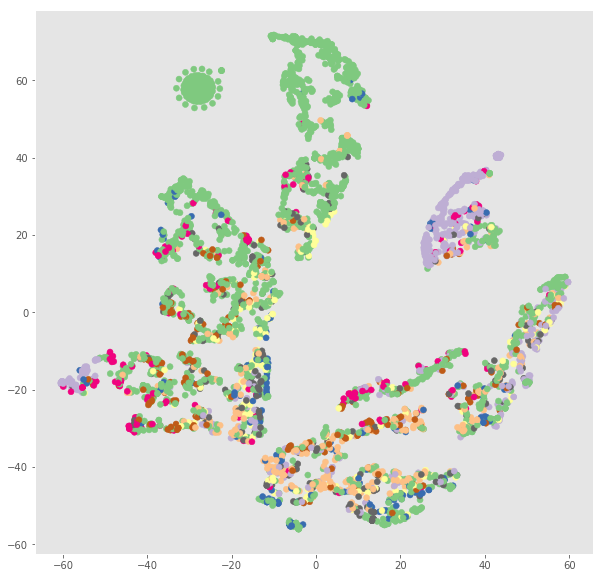

In [103]:
fig, ax = plt.subplots(figsize=(10, 10))
ax.scatter(x3, y3, c=clusters, cmap='Accent')
ax.grid(False)


In [104]:
from sklearn.decomposition import PCA

In [114]:
pca = PCA(n_components=2)

In [121]:
pca.fit_transform(tfidf.todense())

array([[-0.01514374, -0.02617858],
       [ 0.01162662, -0.08346223],
       [-0.04922303,  0.00964325],
       ..., 
       [-0.05574864,  0.00372141],
       [-0.09329557,  0.19963292],
       [ 0.30205774, -0.07718714]])

In [122]:
pc_comp = pca.components_

In [123]:
pc_comp.shape

(2, 500)

In [124]:
x4, y4 = pc_comp[0, :], pc_comp[1, :]

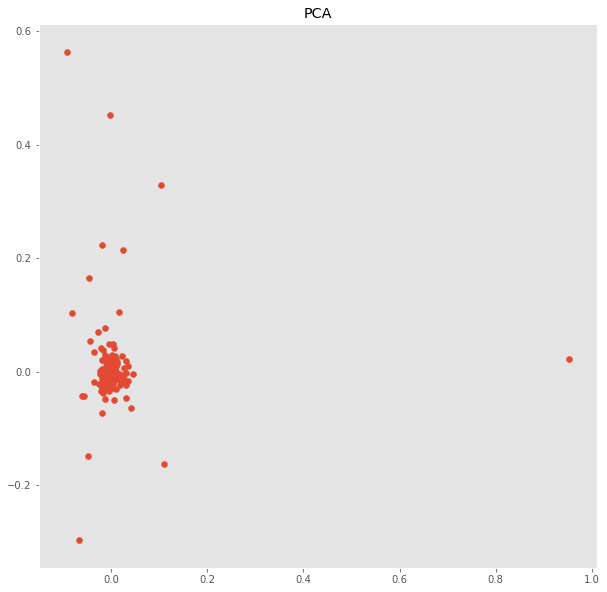

In [125]:
fig, ax = plt.subplots(figsize=(10, 10))
ax.scatter(x4, y4, cmap='Accent')
ax.set_title('PCA')
ax.grid(False)
